# roAp Classification using regression techniques:
    ~ The classification uses a threshold value of 1.5 for all the regressions
### Updates:
* initial: (03/2/2023)
* linear regression: (04/4/2023)
* classification: (04/13/2023)
* polynomial regression classification: (04/18/22023)
* added lasso regression classification: (04/19/2023)
### Needed:
* add poly to generic and FOV plot w roAp and cluster, just to see what's up
* finish project off with adding elastic-net regression and possibly doing a learning curve
* logistic regression possibly??

In [29]:
from sklearn import neighbors, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### 1. Importing csv files containing NGC 2264 and known roAps
        'roAp' is the csv file including the field roAps
        'clust' is the csv file including NGC 2264 cluster stars
        'all' is the concatenated of the two

In [30]:
r = pd.read_csv('Data/field_roAp.csv', index_col=False)
c = pd.read_csv('Data/15MON_A0_FOV.csv', index_col=False)
rfeat = r.columns
cfeat = c.columns

roAp = pd.DataFrame(r)
clust = pd.DataFrame(c)
dbr = np.append(np.array(roAp), np.array(roAp), axis=1)
dbc = np.append(np.array(clust), np.array(clust), axis=1)
# Concatenating datasets to find roAp condidates in NGC 2264
all = pd.concat([roAp, clust],axis=0)
all['designation'] = all['designation'].str.replace(r'\D', '')
db = np.append(np.array(all),np.array(all),axis=1)
# Extracting features of all datasets
yr = (roAp['GMAG0']).values
yc = (clust['GMAG0']).values
xr = (roAp['BP-RP0']).values
xc = (clust['BP-RP0']).values
y = (all['GMAG0']).values
x = (all['BP-RP0']).values

print('Features:', len(yr))
print('Target:', len(yc))
print('---------')
print('Total Dataset for field roAps:', dbr.data.shape)
print('Total Dataset for NGC 2264:', dbc.data.shape)
print('Concatenated Dataset:',all.shape)
all.describe()

Features: 93
Target: 965
---------
Total Dataset for field roAps: (93, 122)
Total Dataset for NGC 2264: (965, 172)
Concatenated Dataset: (1058, 91)


,num,id,ra,RA_ICRS,dec,DE_ICRS,GMAG0,BP-RP0,ecl_lon,ecl_lat,...,grvs_mag,grvs_mag_error,logg_gspphot,mh_gspphot,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_g_mean_flux,phot_g_mean_flux_error,phot_rp_mean_flux,phot_rp_mean_flux_error
count,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,...,127.000000,127.000000,846.000000,846.000000,9.650000e+02,965.000000,9.650000e+02,965.000000,9.650000e+02,965.000000
mean,0.087902,528.500000,109.151299,109.151289,7.478114,7.478106,3.442366,0.757858,109.771502,-13.118243,...,12.503708,0.073577,4.376956,-1.251781,2.165922e+04,74.888334,4.196140e+04,21.822412,2.990228e+04,77.776609
std,0.283286,305.562596,41.211886,41.211825,13.838901,13.838930,2.109317,0.467252,42.045784,12.764718,...,1.210838,0.063511,0.459858,1.033316,1.807347e+05,1115.473325,3.672976e+05,110.827438,2.778614e+05,1033.807892
min,0.000000,0.000000,2.127157,2.127157,-81.902104,-81.902104,-2.724406,-0.274474,2.019759,-85.377605,...,7.257843,0.005903,1.560400,-4.080400,9.493662e+01,5.431366,7.524995e+02,1.351323,7.388467e+02,6.360226
25%,0.000000,264.250000,100.119403,100.119403,9.797506,9.797506,2.154758,0.536962,100.236203,-13.265848,...,12.066604,0.029815,4.194500,-1.636250,3.390643e+02,11.071645,1.269774e+03,2.042505,1.384733e+03,12.372756
50%,0.000000,528.500000,100.244704,100.244704,9.920538,9.920538,3.409107,0.713893,100.364398,-13.137302,...,12.808246,0.062369,4.455300,-1.098800,6.898837e+02,14.236284,2.602011e+03,2.892261,2.781346e+03,15.658791
75%,0.000000,792.750000,100.431403,100.431403,10.019111,10.019111,4.361791,0.921099,100.558289,-13.049704,...,13.332334,0.105035,4.713975,-0.429025,2.274583e+03,20.523827,7.898782e+03,6.651048,8.173050e+03,24.481014
max,1.000000,1057.000000,348.317184,348.305087,58.526905,58.526905,13.284124,3.569711,336.146049,69.335987,...,14.090522,0.507102,5.158000,0.635400,4.076147e+06,34367.074000,9.490580e+06,2162.942900,7.721012e+06,31803.912000


#### ~ Plotting the initial HRD with the field roAps and NGC 2264

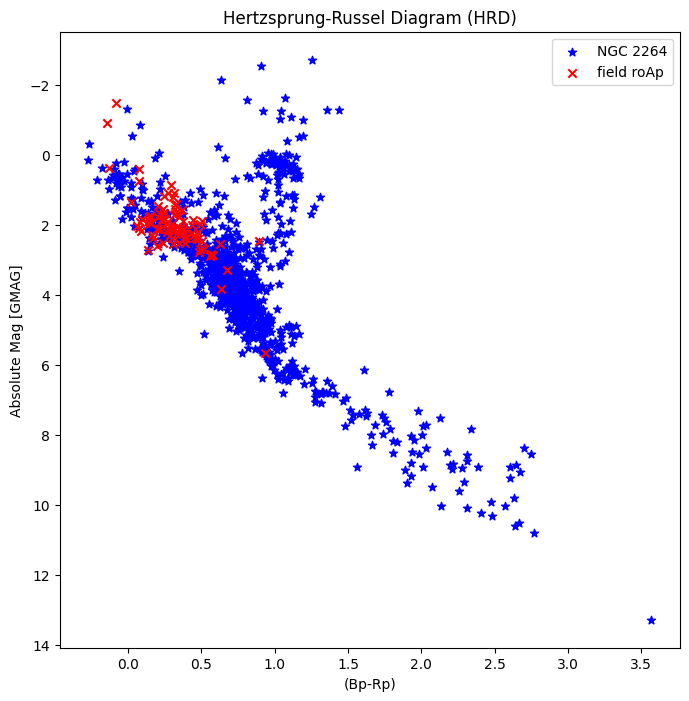

In [31]:
plt.figure(figsize=(8,8))
plt.gca().invert_yaxis()

plt.scatter(x=xc,y=yc,marker='*', c='b', label='NGC 2264')
plt.scatter(x=xr,y=yr,marker='x', c='r', label='field roAp')

plt.legend()
plt.title('Hertzsprung-Russel Diagram (HRD)')
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('(Bp-Rp)')
plt.show()

----

### 2. Splitting the data to be used for training and showing the sizes

In [32]:
# Splitting data 80:20

xtrain, xtest, ytrain, ytest = train_test_split(db[:,np.newaxis,8],
                                                db[:,7],train_size=0.8)

xtrain_r, xtest_r, ytrain_r, ytest_r = train_test_split(dbr[:,np.newaxis,8],
                                                        dbr[:,7],train_size=0.8)

xtrain_c, xtest_c, ytrain_c, ytest_c = train_test_split(dbc[:,np.newaxis,8],
                                                        dbc[:,7],train_size=0.8)

scalar = preprocessing.StandardScaler().fit(xtrain)
xtrain = scalar.transform(xtrain)
xtest = scalar.transform(xtest)

print(f"roAp->\nTrain: {xtrain_r.shape}, Label: {ytrain_r.shape}")
print(f"Test: {xtest_r.shape}, Label: {ytest_r.shape}")
print('-----------------')
print(f"cluster->\nTrain: {xtrain_c.shape}, Label: {ytrain_c.shape}")
print(f"Test: {xtest_c.shape}, Label: {ytest_c.shape}")
print('-----------------')
print(f"Concat->\nTrain: {xtrain.shape}, Label: {ytrain.shape}")
print(f"Test: {xtest.shape}, Label: {ytest.shape}")

roAp->
Train: (74, 1), Label: (74,)
Test: (19, 1), Label: (19,)
-----------------
cluster->
Train: (772, 1), Label: (772,)
Test: (193, 1), Label: (193,)
-----------------
Concat->
Train: (846, 1), Label: (846,)
Test: (212, 1), Label: (212,)


----

### 3. Training the Linear Regression model and plotting with the HRD
        Do this but with polynomial, lets see what the cluster gives!

Coefficient for roAp or slope(m) in y = mx+b: [3.07441656]
Coefficient for cluster or slope(m) in y = mx+b: [3.10785599]

Mean squared error for roAp: 0.26
Mean squared error for cluster: 2.27

Coefficient of determination for roAp: 0.50
Coefficient of determination for cluster: 0.53


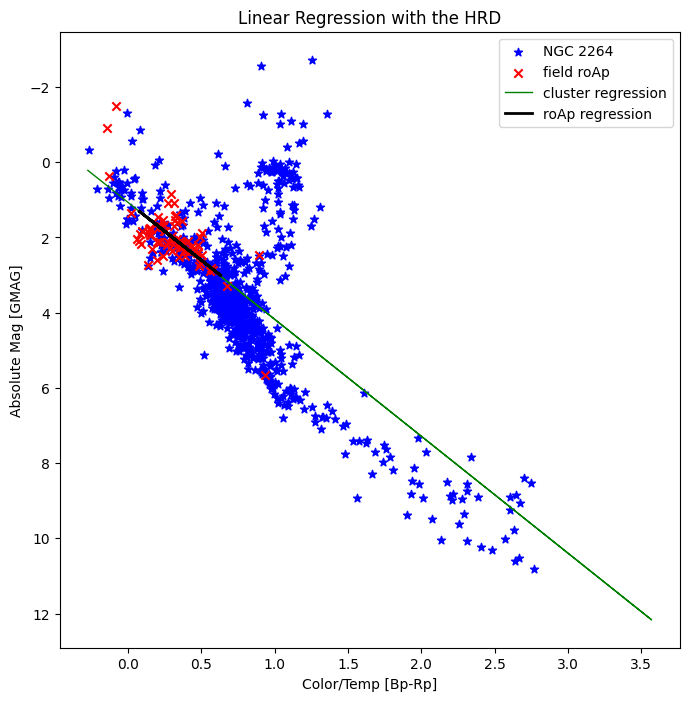

In [33]:
regr = LinearRegression()
regc = LinearRegression()
# Fitting/Training the model
regr.fit(xtrain_r,ytrain_r)
regc.fit(xtrain_c,ytrain_c)
# Predictions
data_r_pred = regr.predict(xtest_r)
data_c_pred = regc.predict(xtest_c)

# The coefficients
print(f"Coefficient for roAp or slope(m) in y = mx+b: {regr.coef_}")
print(f"Coefficient for cluster or slope(m) in y = mx+b: {regc.coef_}")
# The mean squared error
print("\nMean squared error for roAp: %.2f" % mean_squared_error(ytest_r, data_r_pred ))
print("Mean squared error for cluster: %.2f" % mean_squared_error(ytest_c, data_c_pred ))
# The coefficient of determination: 1 is perfect prediction
print("\nCoefficient of determination for roAp: %.2f" % r2_score(ytest_r, data_r_pred ))
print("Coefficient of determination for cluster: %.2f" % r2_score(ytest_c, data_c_pred ))

plt.figure(figsize=(8,8))
plt.gca().invert_yaxis()
plt.title('Linear Regression with the HRD')

plt.scatter(x=xtrain_c,y=ytrain_c,marker='*', c='b', label='NGC 2264')
plt.scatter(x=xtrain_r,y=ytrain_r,marker='x', c='r', label='field roAp')
plt.plot(xtest_c,data_c_pred,c='green',linewidth=1,label='cluster regression')
plt.plot(xtest_r,data_r_pred,c='black',linewidth=2,label='roAp regression')

plt.legend()
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.savefig('Figures/LinearRegHRD-both')

----

### 4. Training and plotting the concatenated dataset with the linear regression

#### ~ The following shows the FOV we want to apply the regresion models to, with the cluster data:

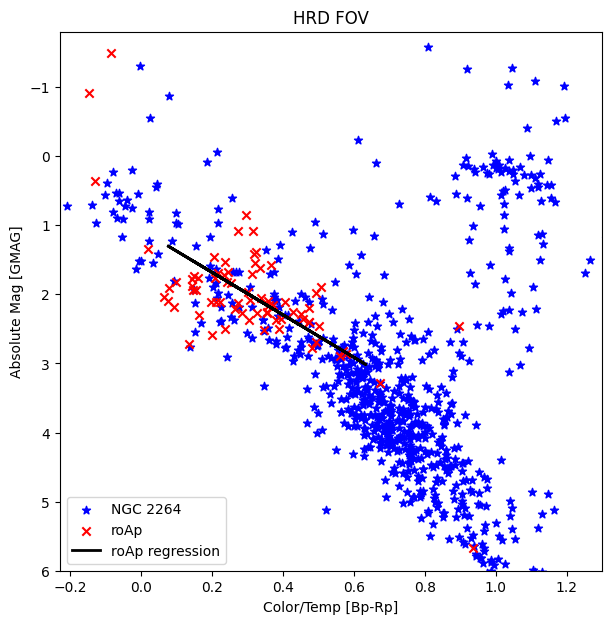

In [34]:
plt.figure(figsize=(7,7))
plt.title('HRD FOV')

plt.ylim([-1.8,6])
plt.xlim([-0.23,1.3])

plt.scatter(x=xtrain_c,y=ytrain_c,marker='*', c='b', label='NGC 2264')
plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
plt.plot(xtest_r,data_r_pred,c='black',linewidth=2,label='roAp regression')

plt.gca().invert_yaxis()

plt.legend()
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.savefig('Figures/LinearRegHRD-concat.png')

#### ~ Fitting the roAp's regression to the concatenated dataset and finding the deviations:

In [35]:
# For field roAp's
regr.fit(xtrain_r,ytrain_r)
pred = regr.predict(xtrain)
predr = regr.predict(xtrain_r)

print("Regression Coefficient:", regr.coef_[0])
dist = np.abs(ytrain - pred)
print('Length of the deviation list:', len(dist))

Regression Coefficient: 3.0744165579167446
Length of the deviation list: 846


#### ~ Computing which cluster stars are potential candidates using the deviations, threshold value, and the maximum B-R value:

In [36]:
print('Stars in NGC 2264 following the Linear regression:')
cands = []
thresh = 1.5
max = (xr.max()) + 0.5
for n in range(len(ytrain)):
    if (dist[n]<thresh) & (xtrain[n]<max):
        cand = clust.iloc[n]['id']
        print('Deviation:', dist[n],'| ID:',cand, '| GMAG:', ytrain[n], '| B-R: ', xtrain[n][0])
        cands.append({'ID':cand,'Deviation':dist[n],'GMAG':ytrain[n],'B-R':xtrain[n][0]})

Stars in NGC 2264 following the Linear regression:
Deviation: 0.19601049054274844 | ID: 143 | GMAG: 0.694696 | B-R:  -0.05801860765520927
Deviation: 1.2123429836205886 | ID: 151 | GMAG: 3.741228 | B-R:  0.47482347635526356
Deviation: 0.4104395546885611 | ID: 158 | GMAG: 2.458177 | B-R:  0.3183230275696239
Deviation: 0.13823464502449712 | ID: 161 | GMAG: 3.168816 | B-R:  0.6380077193311231
Deviation: 1.454455069402103 | ID: 190 | GMAG: 2.661548 | B-R:  0.044890817302329675
Deviation: 1.4718563046100492 | ID: 257 | GMAG: 2.599674 | B-R:  0.019105360545076163
Deviation: 0.7231824190883005 | ID: 293 | GMAG: 3.700664 | B-R:  0.6207362230769576
Deviation: 0.8000203567592408 | ID: 299 | GMAG: 2.892737 | B-R:  0.3329531848960593
Deviation: 0.7984612843227059 | ID: 325 | GMAG: 2.847243 | B-R:  0.3186626921356262
Deviation: 0.563141321756766 | ID: 346 | GMAG: 2.692483 | B-R:  0.344866025694475
Deviation: 0.9690979124600199 | ID: 348 | GMAG: 0.64592 | B-R:  0.17757452303234864
Deviation: 1.478645

### 5. Exporting potential candidates

#### ~ Writing the data to a csv file:

In [37]:
print(len(cands))
df = pd.DataFrame(cands)
df.to_csv('Data/linear-candidates.csv',index=False,header=True)
df.describe()

57


,ID,Deviation,GMAG,B-R
count,57.000000,57.000000,57.000000,57.000000
mean,573.631579,0.914313,2.595286,0.388496
std,229.497715,0.426416,1.466219,0.403135
min,143.000000,0.026272,-0.228720,-0.346590
25%,381.000000,0.639954,1.780438,0.126877
50%,589.000000,1.073035,2.505641,0.381174
75%,781.000000,1.265088,2.959737,0.637458
max,931.000000,1.478645,6.792743,1.429567


#### ~ Displaying the candidates with the roAp's:

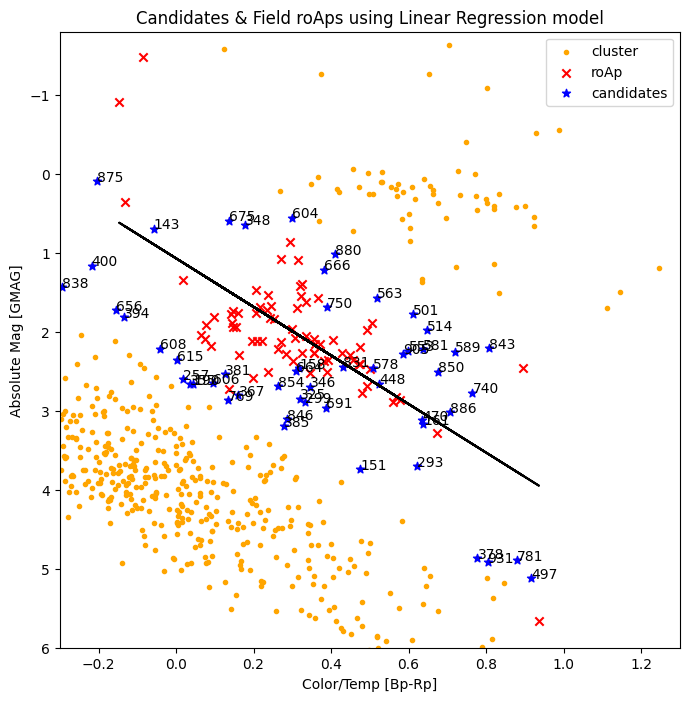

In [38]:
a1 = df['B-R']
b1 = df['GMAG']

plt.figure(figsize=(8,8))
plt.ylim([-1.8,6])
plt.xlim([-0.3,1.3])

plt.gca().invert_yaxis()
plt.title('Candidates & Field roAps using Linear Regression model')

plt.scatter(xtrain,ytrain,marker='.',c='orange',label='cluster')
plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
plt.scatter(a1,b1,marker='*',c='b',label='candidates')
plt.plot(xtrain_r,predr,c='black')

plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.legend()

for i, id in enumerate(df['ID']):
    plt.annotate(id, (a1[i],b1[i]))

plt.savefig('Figures/Linear-Candidates')
plt.show()

### 6. Showing which degree is best to fit to data for no under/over fitting

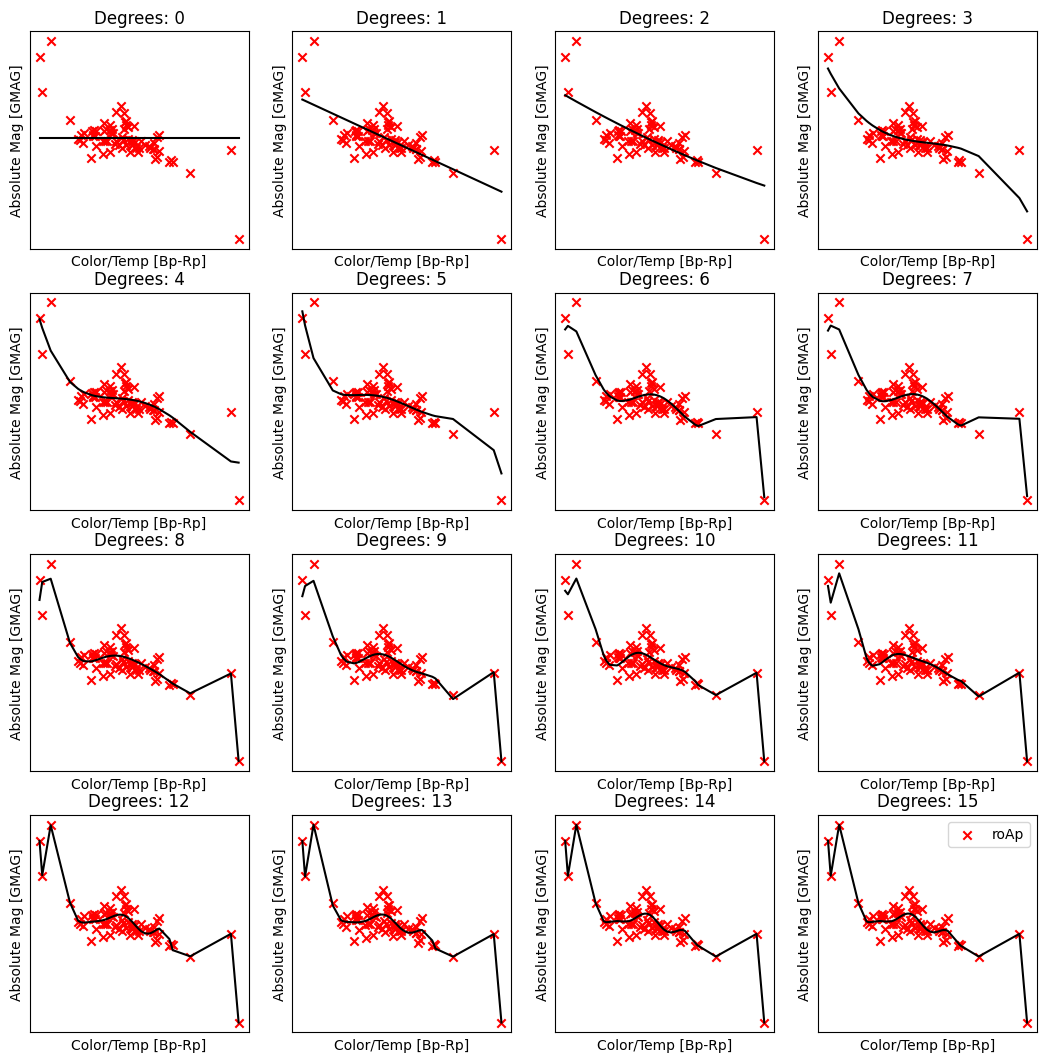

In [39]:
# Flattening the series for the x-values and prediction values
xf = pd.Series(xtrain_r.flatten())
# Sorting
xs = xf.sort_values()
# Arraning into an array to plot
xarr = np.array(xs)

plt.figure(figsize=(13,13))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    polyi = PolynomialFeatures(degree=(i))
    regpi = LinearRegression()
    
    pfri = polyi.fit_transform(xtrain_r)
    pfi = polyi.fit_transform(xtrain)

    regpi.fit(pfri, ytrain_r)
    yfi = pd.Series(regpi.predict(pfri).flatten())
    ypredi = np.array(yfi[xs.index])

    plt.gca().invert_yaxis()
    plt.title(f'Degrees: {i}')
    plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
    plt.plot(xarr,ypredi,c='black')
    
    plt.ylabel('Absolute Mag [GMAG]')
    plt.xlabel('Color/Temp [Bp-Rp]')
    plt.savefig('Figures/ith-deg-Polynomial-roAp')
plt.legend()

### 7. Training and plottting the concatenated dataset using polynomial regression
        5 degrees being used, chosen from subplot

In [40]:
deg = 5
poly = PolynomialFeatures(degree=deg, include_bias=False)
regp = LinearRegression()

pfr = poly.fit_transform(xtrain_r)
pf = poly.fit_transform(xtrain)
regp.fit(pfr, ytrain_r)
print('')

#### ~ Predicting, calculating deviation, and exporting candidates then plotting

In [41]:
predp = regp.predict(pf)
predpr = regp.predict(pfr)

print(f'Intercept: {regp.intercept_} and Coefficients: {regp.coef_}')
print('The Mean Squared Error: %.2f' % mean_squared_error(ytrain,pred))
dist = np.abs(ytrain - predp)
print('Length of the deviation list:', len(dist))

Intercept: 1.5893777510760614 and Coefficients: [   6.4341394   -52.60012285  179.91105638 -245.47452145  116.96517523]
The Mean Squared Error: 10.62
Length of the deviation list: 846


In [42]:
print('Stars in NGC 2264 following the Polynomial regression:')
cands = []
thresh = 1.5
max = (xr.max()) + 0.5
for n in range(len(ytrain)):
    if (dist[n]<thresh) & (xtrain[n]<max):
        cand = clust.iloc[n]['id']
        print('Deviation:', dist[n],'| ID:',cand, '| GMAG:', ytrain[n], '| B-R: ', xtrain[n][0])
        cands.append({'ID':cand,'Deviation':dist[n],'GMAG':ytrain[n],'B-R':xtrain[n][0]})

Stars in NGC 2264 following the Polynomial regression:
Deviation: 0.30632659914191884 | ID: 143 | GMAG: 0.694696 | B-R:  -0.05801860765520927
Deviation: 1.3506112933940182 | ID: 151 | GMAG: 3.741228 | B-R:  0.47482347635526356
Deviation: 0.485644785276621 | ID: 158 | GMAG: 2.458177 | B-R:  0.3183230275696239
Deviation: 0.4705535176548139 | ID: 161 | GMAG: 3.168816 | B-R:  0.6380077193311231
Deviation: 0.8740356667521925 | ID: 190 | GMAG: 2.661548 | B-R:  0.044890817302329675
Deviation: 1.4707871235166892 | ID: 207 | GMAG: 3.197263 | B-R:  0.026575746361827905
Deviation: 1.4863372525053284 | ID: 230 | GMAG: 0.602721 | B-R:  0.3686537184911614
Deviation: 0.905347274714001 | ID: 257 | GMAG: 2.599674 | B-R:  0.019105360545076163
Deviation: 1.4055896733374382 | ID: 260 | GMAG: 6.105931 | B-R:  1.0147046615690771
Deviation: 1.0195449307398974 | ID: 293 | GMAG: 3.700664 | B-R:  0.6207362230769576
Deviation: 0.8897752080371237 | ID: 299 | GMAG: 2.892737 | B-R:  0.3329531848960593
Deviation: 0.

In [43]:
print(len(cands))
dfp = pd.DataFrame(cands)
dfp.to_csv('Data/polynomial-candidates.csv',index=False,header=True)
dfp.describe()

56


,ID,Deviation,GMAG,B-R
count,56.000000,56.000000,56.000000,56.000000
mean,533.857143,0.865170,2.529332,0.376977
std,228.223529,0.412666,1.051104,0.279905
min,143.000000,0.017745,0.554031,-0.058019
25%,353.250000,0.510409,2.211893,0.132128
50%,552.500000,0.889771,2.624640,0.356760
75%,741.000000,1.206530,2.953950,0.624085
max,905.000000,1.493049,6.105931,1.014705


#### ~ Displaying graph of roAp candidates with field roAp's using 5 degree polynomial regression

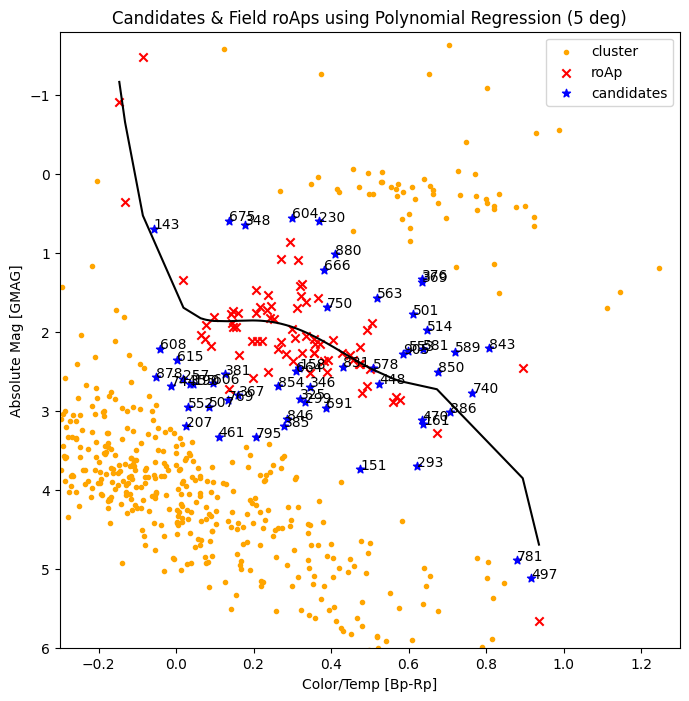

In [44]:
a2 = dfp['B-R']
b2 = dfp['GMAG']
# Flattening the series for the x-values and prediction values
xf = pd.Series(xtrain_r.flatten())
yf = pd.Series(predpr.flatten())
# Sorting
xs = xf.sort_values()
# Arraning into an array to plot
ypred = np.array(yf[xs.index])
xarr = np.array(xs)

plt.figure(figsize=(8,8))
plt.ylim([-1.8,6])
plt.xlim([-0.3,1.3])

plt.gca().invert_yaxis()
plt.title(f'Candidates & Field roAps using Polynomial Regression ({deg} deg)')

plt.scatter(xtrain,ytrain,marker='.',c='orange',label='cluster')
plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
plt.scatter(a2,b2,marker='*',c='b',label='candidates')
plt.plot(xarr,ypred,c='black')

plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.legend()

for i, id in enumerate(dfp['ID']):
    plt.annotate(id, (a2[i],b2[i]))
    
plt.savefig(f'Figures/Polynomial-Candidates-{deg}deg')
plt.show()

### 8. Training and plotting concatenated set with Lasso regression

In [45]:
lreg = Lasso(alpha=.06)

lreg.fit(xtrain_r,ytrain_r)
lpred = lreg.predict(xtrain)
lpredr = lreg.predict(xtrain_r)

print("Regression Coefficient:", lreg.coef_[0])
dist = np.abs(ytrain - lpred)
print('Length of the deviation list:', len(dist))

Regression Coefficient: 1.3935850647432113
Length of the deviation list: 846


#### ~ The slope, coefficient, is very steep, as seen in the plot. This is a discrete value, determined from $\alpha$, here it is 0.06

In [46]:
print('Stars in NGC 2264 following the Lasso regression:')
cands = []
thresh = 1.5
max = (xr.max()) + 0.5
min = (xr.min()) - 0.1
for n in range(len(ytrain)):
    if (dist[n]<thresh) & (xtrain[n]<max) & (xtrain[n]>min):
        cand = clust.iloc[n]['id']
        print('Deviation:', dist[n],'| ID:',cand, '| GMAG:', ytrain[n], '| B-R: ', xtrain[n][0])
        cands.append({'ID':cand,'Deviation':dist[n],'GMAG':ytrain[n],'B-R':xtrain[n][0]})

Stars in NGC 2264 following the Lasso regression:
Deviation: 0.8058847061730543 | ID: 143 | GMAG: 0.694696 | B-R:  -0.05801860765520927
Deviation: 1.4980865236833032 | ID: 151 | GMAG: 3.741228 | B-R:  0.47482347635526356
Deviation: 0.4331322117365808 | ID: 158 | GMAG: 2.458177 | B-R:  0.3183230275696239
Deviation: 0.6982633998707182 | ID: 161 | GMAG: 3.168816 | B-R:  0.6380077193311231
Deviation: 1.017554256184807 | ID: 190 | GMAG: 2.661548 | B-R:  0.044890817302329675
Deviation: 1.4891575840967834 | ID: 206 | GMAG: 0.727716 | B-R:  0.45597432757742895
Deviation: 1.027303198871028 | ID: 229 | GMAG: 2.31832 | B-R:  -0.2083961557115939
Deviation: 1.492463887429881 | ID: 230 | GMAG: 0.602721 | B-R:  0.3686537184911614
Deviation: 0.9916144836092975 | ID: 257 | GMAG: 2.599674 | B-R:  0.019105360545076163
Deviation: 0.9940985402082507 | ID: 273 | GMAG: 2.461227 | B-R:  -0.08202306007625258
Deviation: 1.4141253854965603 | ID: 283 | GMAG: 2.670273 | B-R:  -0.23341736719534195
Deviation: 1.2541

In [47]:
print(len(cands))
dfl = pd.DataFrame(cands)
dfl.to_csv('Data/lasso-candidates.csv',index=False,header=True)
dfl.describe()

72


,ID,Deviation,GMAG,B-R
count,72.000000,72.000000,72.000000,72.000000
mean,552.791667,0.898126,2.259379,0.260303
std,233.259508,0.422949,0.804213,0.331997
min,143.000000,0.017046,0.094609,-0.233417
25%,364.000000,0.598795,1.766185,-0.051362
50%,568.000000,0.971605,2.480212,0.282668
75%,754.750000,1.228727,2.805013,0.539585
max,929.000000,1.498087,3.741228,1.112729


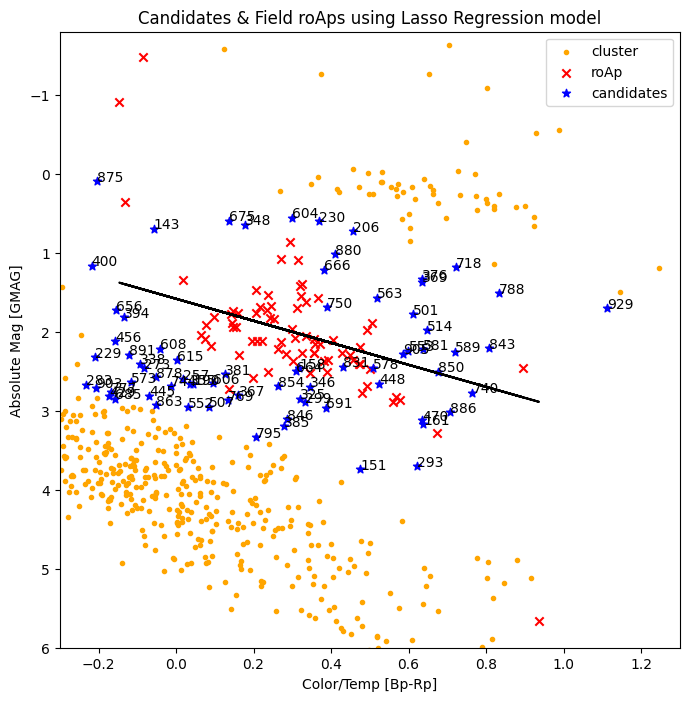

In [48]:
a3 = dfl['B-R']
b3 = dfl['GMAG']

plt.figure(figsize=(8,8))
plt.ylim([-1.8,6])
plt.xlim([-0.3,1.3])

plt.gca().invert_yaxis()
plt.title('Candidates & Field roAps using Lasso Regression model')

plt.scatter(xtrain,ytrain,marker='.',c='orange',label='cluster')
plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
plt.scatter(a3,b3,marker='*',c='b',label='candidates')
plt.plot(xtrain_r,lpredr,c='black')

plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.legend()

for i, id in enumerate(dfl['ID']):
    plt.annotate(id, (a3[i],b3[i]))
    
plt.savefig('Figures/Lasso-Candidates')
plt.show()

### 9. Elastic Net Regression

In [49]:
ereg = ElasticNet(alpha=.06)

ereg.fit(xtrain_r,ytrain_r)
epred = ereg.predict(xtrain)
epredr = ereg.predict(xtrain_r)

print("Regression Coefficient:", ereg.coef_[0])
dist = np.abs(ytrain - epred)
print('Length of the deviation list:', len(dist))

Regression Coefficient: 1.2138566057550604
Length of the deviation list: 846


In [50]:
print('Stars in NGC 2264 following the Elastic Net regression:')
cands = []
thresh = 1.5
max = (xr.max()) + 0.5
min = (xr.min()) - 0.1
for n in range(len(ytrain)):
    if (dist[n]<thresh) & (xtrain[n]<max) & (xtrain[n]>min):
        cand = clust.iloc[n]['id']
        print('Deviation:', dist[n],'| ID:',cand, '| GMAG:', ytrain[n], '| B-R: ', xtrain[n][0])
        cands.append({'ID':cand,'Deviation':dist[n],'GMAG':ytrain[n],'B-R':xtrain[n][0]})

Stars in NGC 2264 following the Elastic Net regression:
Deviation: 0.8710975210191678 | ID: 143 | GMAG: 0.694696 | B-R:  -0.05801860765520927
Deviation: 0.4355586990425073 | ID: 158 | GMAG: 2.458177 | B-R:  0.3183230275696239
Deviation: 0.7581463241890414 | ID: 161 | GMAG: 3.168816 | B-R:  0.6380077193311231
Deviation: 0.9708371937016687 | ID: 190 | GMAG: 2.661548 | B-R:  0.044890817302329675
Deviation: 1.4619912407627385 | ID: 206 | GMAG: 0.727716 | B-R:  0.45597432757742895
Deviation: 0.9350632590463237 | ID: 229 | GMAG: 2.31832 | B-R:  -0.2083961557115939
Deviation: 1.4809915426048175 | ID: 230 | GMAG: 0.602721 | B-R:  0.3686537184911614
Deviation: 1.4467605255172884 | ID: 256 | GMAG: 2.835936 | B-R:  -0.20352018148121648
Deviation: 0.9402630407188723 | ID: 257 | GMAG: 2.599674 | B-R:  0.019105360545076163
Deviation: 1.4952879612044851 | ID: 259 | GMAG: 3.423136 | B-R:  0.2402493393657131
Deviation: 0.9245714421196487 | ID: 273 | GMAG: 2.461227 | B-R:  -0.08202306007625258
Deviation

In [51]:
print(len(cands))
dfe = pd.DataFrame(cands)
dfe.to_csv('Data/elastic-net-candidates.csv',index=False,header=True)
dfe.describe()

77


,ID,Deviation,GMAG,B-R
count,77.000000,77.000000,77.000000,77.000000
mean,540.415584,0.907878,2.276149,0.244913
std,229.986747,0.421072,0.796254,0.337538
min,143.000000,0.049561,0.094609,-0.233417
25%,351.000000,0.626137,1.780438,-0.061167
50%,552.000000,0.940263,2.505641,0.240249
75%,744.000000,1.288980,2.835936,0.524305
max,929.000000,1.495288,3.700664,1.112729


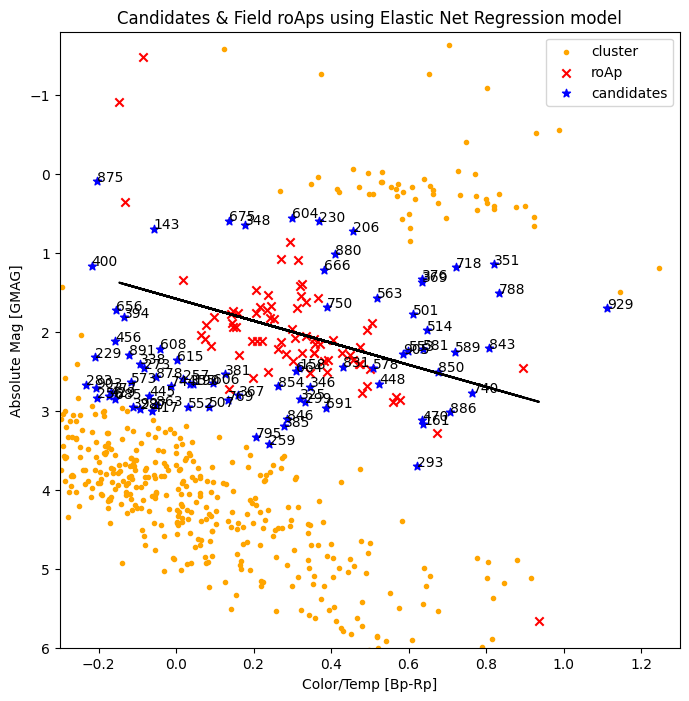

In [52]:
a4 = dfe['B-R']
b4 = dfe['GMAG']

plt.figure(figsize=(8,8))
plt.ylim([-1.8,6])
plt.xlim([-0.3,1.3])

plt.gca().invert_yaxis()
plt.title('Candidates & Field roAps using Elastic Net Regression model')

plt.scatter(xtrain,ytrain,marker='.',c='orange',label='cluster')
plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
plt.scatter(a4,b4,marker='*',c='b',label='candidates')
plt.plot(xtrain_r,lpredr,c='black')

plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.legend()

for i, id in enumerate(dfe['ID']):
    plt.annotate(id, (a4[i],b4[i]))
    
plt.savefig('Figures/Elastic-Net-Candidates')
plt.show()

### 10. Plotting and exporting all 3 regression model candidates, so we have new and repeated stars
        Still need to export the repeated and new stars; possibly a csv file for each, new, both, and all

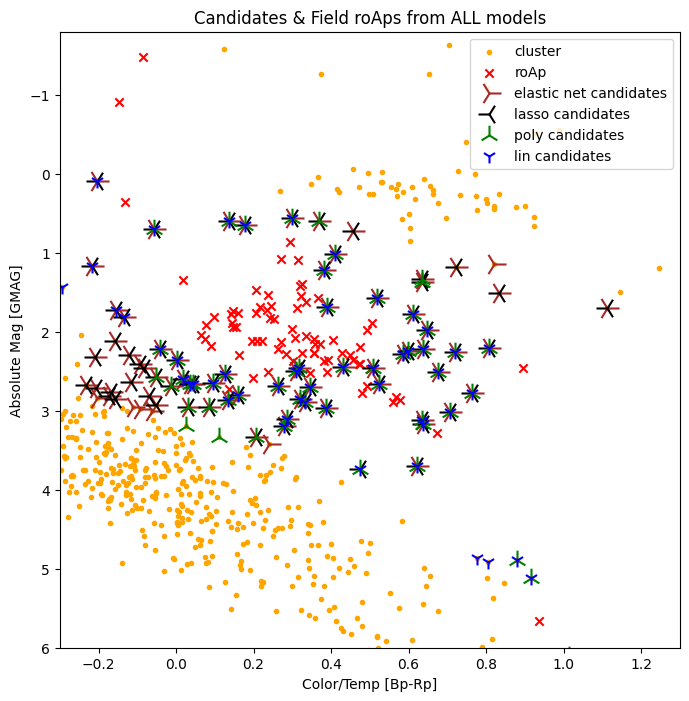

In [53]:
plt.figure(figsize=(8,8))
plt.ylim([-1.8,6])
plt.xlim([-0.3,1.3])
plt.gca().invert_yaxis()
plt.title('Candidates & Field roAps from ALL models')

plt.scatter(xtrain,ytrain,marker='.',c='orange',label='cluster')
plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
plt.scatter(a4,b4,marker='4',s=300,c='brown',label='elastic net candidates')
plt.scatter(a3,b3,marker='3',s=250,c='black',label='lasso candidates')
plt.scatter(a2,b2,marker='2',s=200,c='g',label='poly candidates')
plt.scatter(a1,b1,marker='1',s=100,c='b',label='lin candidates')

plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.legend()
    
plt.savefig('Figures/ALL-reg-Candidates')
plt.show()